<a href="https://cognitiveclass.ai"><img src = "https://ibm.box.com/shared/static/9gegpsmnsoo25ikkbl4qzlvlyjbgxs5x.png" width = 400> </a>

<h1 align=center><font size = 5>Segmenting and Clustering Neighborhoods in Toronto City</font></h1>
<h1 align=center><font size = 5>Moaeed Sajid - May 2020</font></h1>
<h1 align=center><font size = 5>Part 3</font></h1>


## Introduction

In this assignment, we will explore, segment, and cluster the neighborhoods in the city of Toronto. However, unlike New York, the neighborhood data is not readily available on the internet. This will require me to be agile and refine my skills to learn new libraries and tools quickly depending on the project.

*Part 1*

For the Toronto neighborhood data, a Wikipedia page exists that has all the information we need to explore and cluster the neighborhoods in Toronto. We will scrape the Wikipedia page and wrangle the data, clean it, and then read it into a pandas dataframe so that it is in a structured format like the New York dataset.

*Part 2*

Import the latitude and longtitude of each area

*Part 3*

Once the data is in a structured format, replicate the analysis applied to the New York City dataset, to explore and cluster the neighborhoods in the city of Toronto.

#### Load our DataFrame from CSV File


In [5]:
import pandas as pd 

dfToronto = pd.read_csv('dfTorontoLL.csv', header = 0)
display(dfToronto)

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.752935,-79.335641
1,M4A,North York,Victoria Village,43.728102,-79.311890
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.650964,-79.353041
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.723265,-79.451211
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.661790,-79.389390
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653340,-79.509766
99,M4Y,Downtown Toronto,Church and Wellesley,43.666659,-79.381472
100,M7Y,East Toronto,Business reply mail Processing Centre,43.648700,-79.385450
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.632798,-79.493017


### Let's just get those areas with Toronto in the Borough

UPDATE - This was not giving a good model so we will work with all the postcodes

In [3]:
# Create a dataframe with neighbourhoods with Toronto in the borough
#dfTorontoOnly = dfToronto[dfToronto['Borough'].str.contains('Toronto')]
#dfTorontoOnly.reset_index(drop = True, inplace = True)
#display(dfTorontoOnly)

### Create a map of Toronto Boroughs using Folium


In [117]:
# We will need the central co-ordinates for Toronto
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

# create map of Toroto using latitude and longitude values
import folium
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, postalcode, neighbourhood in zip(dfToronto['Latitude'], 
dfToronto['Longitude'], dfToronto['PostalCode'], dfToronto['Neighbourhood']):
    label = '{}  ({})'.format(postalcode, neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

The geograpical coordinates of Toronto are 43.6534817, -79.3839347.


### Map Display for Github

The above map may not always display in Github so below is an alterntative solution

In [119]:
from IPython.core.display import HTML
HTML(map_toronto._repr_html_())

### Define FourSquare Credentials



In [8]:

sys.path.append('../') # Credentials file is in a sub directory so allow it to be loaded 
import credentials
# Below 2 lines required if credentials had been updated
#from importlib import reload
#reload(credentials)

CLIENT_ID = credentials.foursquare['client_id']# your Foursquare ID
CLIENT_SECRET = credentials.foursquare['client_secret'] # your Foursquare Secret
ACCESS_TOKEN = credentials.foursquare['access_token']
VERSION = '20180605'

print("FourSquare Credentials Retrieved")

FourSquare Credentials Retrieved


### Code to Retrieve FourSquare information for each area

The following function will retrieve our Foursquares information for each neighbourhood.  I have added in *time* and *day* values so it covers the whole week rather than just the time the query is run.  

I have also sorted locations by popularity.

This function is to be run in the next section




In [10]:
def getNearbyVenues(names, neighbourhoods, latitudes, longitudes, radius=500, limit=100):
    
    venues_list=[]
    for name, neighbourhood, lat, lng in zip(names, neighbourhoods, latitudes, longitudes):
        print('\r',name, end='')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&time=any&day=any&sortByPopularity=1&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        #return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            neighbourhood, 
            lat, 
            lng,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    print(venues_list)

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    print(nearby_venues)
    nearby_venues.columns = ['PostalCode', 
                  'Neighbourhood', 
                  'PostalCode Latitude',
                  'PostalCode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Retrieveing area information for each set of neighbourhoods


In [11]:
import requests

toronto_venues = getNearbyVenues(names=dfToronto['PostalCode'],
                                   neighbourhoods=dfToronto['Neighbourhood'],
                                   latitudes=dfToronto['Latitude'],
                                   longitudes=dfToronto['Longitude']
                                  )

print(" \nThe shape of the toronto venues dataframe is {}".format(toronto_venues.shape))

print("\nThe following table shows how many venues were returned for each postcode \n")
display(toronto_venues[['PostalCode', 'Venue']].groupby('PostalCode').count())
print('\n There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

99999993, 'Pizzeria Libretto', 43.64833354686235, -79.38511050184168, 'Pizza Place'), ('M7Y', 'Business reply mail Processing Centre', 43.648700000000076, -79.38544999999993, 'Drake One Fifty', 43.649589523564934, -79.38455694587901, 'Restaurant'), ('M7Y', 'Business reply mail Processing Centre', 43.648700000000076, -79.38544999999993, 'Royal Alexandra Theatre', 43.647255, -79.38753, 'Theater'), ('M7Y', 'Business reply mail Processing Centre', 43.648700000000076, -79.38544999999993, 'Ki Modern Japanese + Bar', 43.647167, -79.379608, 'Japanese Restaurant'), ('M7Y', 'Business reply mail Processing Centre', 43.648700000000076, -79.38544999999993, 'Cactus Club Cafe', 43.6495520142626, -79.38167072512041, 'American Restaurant'), ('M7Y', 'Business reply mail Processing Centre', 43.648700000000076, -79.38544999999993, 'Pilot Coffee Roasters', 43.648835391245896, -79.3809358125033, 'Coffee Shop'), ('M7Y', 'Business reply mail Processing Centre', 43.648700000000076, -79.38544999999993, 'Cafe La

,Venue
PostalCode,
M1B,1
M1C,1
M1E,20
M1G,3
M1H,1
...,...
M9N,5
M9P,7
M9R,8



 There are 261 uniques categories.


In [12]:
toronto_venues


,PostalCode,Neighbourhood,PostalCode Latitude,PostalCode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M3A,Parkwoods,43.752935,-79.335641,Brookbanks Park,43.751976,-79.332140,Park
1,M3A,Parkwoods,43.752935,-79.335641,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,M3A,Parkwoods,43.752935,-79.335641,Three Valleys Park,43.751195,-79.337356,Park
3,M4A,Victoria Village,43.728102,-79.311890,Wigmore Park,43.731023,-79.310771,Park
4,M4A,Victoria Village,43.728102,-79.311890,Tim Hortons,43.725517,-79.313103,Coffee Shop
...,...,...,...,...,...,...,...,...
2270,M8Z,"Mimico NW, The Queensway West, South of Bloor,...",43.625490,-79.526000,Burrito Boyz,43.621791,-79.522601,Burrito Place
2271,M8Z,"Mimico NW, The Queensway West, South of Bloor,...",43.625490,-79.526000,Tactical Products Canada,43.626801,-79.529388,Miscellaneous Shop
2272,M8Z,"Mimico NW, The Queensway West, South of Bloor,...",43.625490,-79.526000,Mangosteens Thai Cuisine,43.621419,-79.524771,Thai Restaurant
2273,M8Z,"Mimico NW, The Queensway West, South of Bloor,...",43.625490,-79.526000,Global Pet Foods,43.621304,-79.526146,Pet Store


### Prepare for our K-means algorithm

In [13]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add postalcode column back to dataframe and move to the front
toronto_onehot['PostalCode'] = toronto_venues['PostalCode']
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

print("\n The shape of our venues dataframe after one hot encoding is {}\n,".format(toronto_onehot.shape))
display(toronto_onehot.head())

print("\n Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category \n")

toronto_grouped = toronto_onehot.groupby('PostalCode').mean().reset_index()
print("\n The shape of our venues dataframe after taking the mean frequency is {}\n ,".format(toronto_grouped.shape))

display(toronto_grouped)

print("\n The top 5 venues for each postcode are... \n"),

num_top_venues = 5

for postalCode in toronto_grouped['PostalCode']:
    print("----"+postalCode+"----")
    temp = toronto_grouped[toronto_grouped['PostalCode'] == postalCode].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[2:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

print("\n This is good but let's select the top 10 venues, sort them and put that into a pandas dataframe \n")

#First, let's write a function to sort the venues in descending order.

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#Now let's create the new dataframe and display the top 10 venues for each neighborhood.
import numpy as np

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['PostalCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
postalCode_venues_sorted = pd.DataFrame(columns=columns)
postalCode_venues_sorted['PostalCode'] = toronto_grouped['PostalCode']

for ind in np.arange(toronto_grouped.shape[0]):
    postalCode_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

display(postalCode_venues_sorted)


 The shape of our venues dataframe after one hot encoding is (2275, 262)
,


,PostalCode,Accessories Store,Afghan Restaurant,Airport,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,M3A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M3A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M3A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M4A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M4A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



 Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category 


 The shape of our venues dataframe after taking the mean frequency is (102, 262)
 ,


,PostalCode,Accessories Store,Afghan Restaurant,Airport,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,M1B,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,M1C,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,M1E,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,M1G,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,M1H,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,M9N,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
98,M9P,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
99,M9R,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
100,M9V,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.0


 are... 

----M1B----
                     venue  freq
0                    Trail   1.0
1        Afghan Restaurant   0.0
2                   Museum   0.0
3             Night Market   0.0
4  New American Restaurant   0.0


----M1C----
                             venue  freq
0                    Moving Target   1.0
1                Afghan Restaurant   0.0
2        Middle Eastern Restaurant   0.0
3       Modern European Restaurant   0.0
4  Molecular Gastronomy Restaurant   0.0


----M1E----
                    venue  freq
0             Pizza Place  0.10
1    Fast Food Restaurant  0.10
2             Coffee Shop  0.10
3  Thrift / Vintage Store  0.05
4            Intersection  0.05


----M1G----
               venue  freq
0        Coffee Shop  0.67
1  Korean Restaurant  0.33
2  Afghan Restaurant  0.00
3        Music Venue  0.00
4       Noodle House  0.00


----M1H----
                             venue  freq
0       Construction & Landscaping   1.0
1               Miscellaneous Shop   0.0
2

,PostalCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Trail,Yoga Studio,Fast Food Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant,Farm,Farmers Market,Field,Donut Shop
1,M1C,Moving Target,Yoga Studio,Fountain,Food Court,Food & Drink Shop,Food,Flower Shop,Fish Market,Fish & Chips Shop,Field
2,M1E,Pizza Place,Coffee Shop,Fast Food Restaurant,Thrift / Vintage Store,Convenience Store,Restaurant,Mexican Restaurant,Breakfast Spot,Sports Bar,Fried Chicken Joint
3,M1G,Coffee Shop,Korean Restaurant,Fast Food Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant,Farm,Farmers Market,Yoga Studio,Eastern European Restaurant
4,M1H,Construction & Landscaping,Fountain,Food Court,Food & Drink Shop,Food,Flower Shop,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant
...,...,...,...,...,...,...,...,...,...,...,...
97,M9N,Breakfast Spot,Deli / Bodega,Pharmacy,Farmers Market,Park,Ethiopian Restaurant,Falafel Restaurant,Farm,Fast Food Restaurant,Field
98,M9P,Pizza Place,Intersection,Sandwich Place,Discount Store,Coffee Shop,Chinese Restaurant,Field,Fast Food Restaurant,Farmers Market,Donut Shop
99,M9R,Liquor Store,Coffee Shop,Pizza Place,Pharmacy,American Restaurant,Bank,Sandwich Place,Shopping Mall,Ethiopian Restaurant,Falafel Restaurant
100,M9V,Pizza Place,Hardware Store,Beer Store,Japanese Restaurant,Grocery Store,Fast Food Restaurant,Fried Chicken Joint,Caribbean Restaurant,Park,Video Store


### Let's cluster this using K-Means


,K,Silhouette,Harabasz
0,2.0,0.431208,10.693517
1,3.0,0.263447,10.881520
2,4.0,0.339734,8.942471
3,5.0,0.272254,8.167518
4,6.0,0.338268,7.924136
5,7.0,0.108155,7.529511
6,8.0,0.282854,8.029575
7,9.0,0.151339,7.692126
8,10.0,0.077469,7.432944
9,11.0,0.063899,7.530491


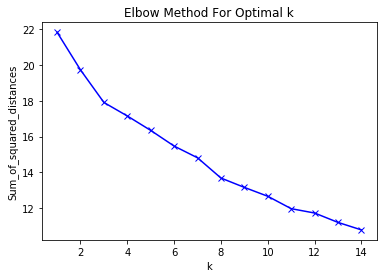

In [15]:
# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

# set number of clusters
K = range(1,15)
metricScoresDf = pd.DataFrame(columns=('K','Silhouette', ' Harabasz'))

toronto_grouped_clustering = toronto_grouped.drop('PostalCode', 1)

# run k-means clustering
Sum_of_squared_distances = []
for k in K:
    k_means = KMeans(n_clusters=k, random_state = 0)
    model = k_means.fit(toronto_grouped_clustering)
    Sum_of_squared_distances.append(k_means.inertia_)
    y_hat = k_means.predict(toronto_grouped_clustering)
    labels = k_means.labels_
    if k != 1:
        silhouette = metrics.silhouette_score(toronto_grouped_clustering, labels, metric = 'euclidean')
        harabasz = metrics.calinski_harabasz_score(toronto_grouped_clustering, labels)
        metricScoresDf = metricScoresDf.append({'K':k,'Silhouette':silhouette, ' Harabasz':harabasz}, ignore_index = True)

display(metricScoresDf)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()
# check cluster labels generated for each row in the dataframe
#kmeans.labels_[0:10] 

### Poor Model

This model has not produced a good result.  It looks like businesses from other postcodes are overlapping so we will see if we can improve our model by only selecting items with a matching postalcode

In [16]:
def getNearbyVenues(names, neighbourhoods, latitudes, longitudes, radius=500, limit=100):
    
    venues_list=[]
    for name, neighbourhood, lat, lng in zip(names, neighbourhoods, latitudes, longitudes):
        print('\r',name, end='')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&time=any&day=any&sortByPopularity=1&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        #return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            neighbourhood, 
            lat, 
            lng,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'], 
            v['venue']['location']['formattedAddress'], 
            v['venue']['categories'][0]['name']) for v in results])
    #print(venues_list)

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    #print(nearby_venues)
    nearby_venues.columns = ['PostalCode', 
                  'Neighbourhood', 
                  'PostalCode Latitude',
                  'PostalCode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Address', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
toronto_venues = getNearbyVenues(names=dfToronto['PostalCode'],
                                 neighbourhoods=dfToronto['Neighbourhood'],
                                 latitudes=dfToronto['Latitude'],
                                 longitudes=dfToronto['Longitude']
                                )

print(" \nThe shape of the toronto venues dataframe is {}".format(toronto_venues.shape))

print("\nThe following table shows how many venues were returned for each postcode \n")
display(toronto_venues[['PostalCode', 'Venue']].groupby('PostalCode').count())
print('\n There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))


M8Z 
The shape of the toronto venues dataframe is (2275, 9)

The following table shows how many venues were returned for each postcode 



,Venue
PostalCode,
M1B,1
M1C,1
M1E,20
M1G,3
M1H,1
...,...
M9N,5
M9P,7
M9R,8



 There are 261 uniques categories.


In [19]:
# Convert address to string so we can work with it
toronto_venues['Venue Address'] = toronto_venues['Venue Address'].astype(str)

# Postcode format for first three letters
postcode = r'(M\d[A-Z])'

#Extract postcode and add it to a new column
toronto_venues['Venue PostalCode'] = toronto_venues['Venue Address'].str.extract(postcode)
display(toronto_venues)

# New dataframe with only those venues where the postcode matches
clean_venues = toronto_venues[toronto_venues['PostalCode'] == toronto_venues['Venue PostalCode']]
display(clean_venues)

,PostalCode,Neighbourhood,PostalCode Latitude,PostalCode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Address,Venue Category,Venue PostalCode
0,M3A,Parkwoods,43.752935,-79.335641,Brookbanks Park,43.751976,-79.332140,"['Toronto', 'Toronto ON', 'Canada']",Park,NaN
1,M3A,Parkwoods,43.752935,-79.335641,Variety Store,43.751974,-79.333114,"['29 Valley Woods Road', 'Toronto ON', 'Canada']",Food & Drink Shop,NaN
2,M3A,Parkwoods,43.752935,-79.335641,Three Valleys Park,43.751195,-79.337356,['Canada'],Park,NaN
3,M4A,Victoria Village,43.728102,-79.311890,Wigmore Park,43.731023,-79.310771,"['Toronto ON', 'Canada']",Park,NaN
4,M4A,Victoria Village,43.728102,-79.311890,Tim Hortons,43.725517,-79.313103,"['1733 Eglinton Ave East (at Bermondsey Rd)', ...",Coffee Shop,M4A
...,...,...,...,...,...,...,...,...,...,...
2270,M8Z,"Mimico NW, The Queensway West, South of Bloor,...",43.625490,-79.526000,Burrito Boyz,43.621791,-79.522601,"['1197 The Queensway (at Kipling)', 'Toronto O...",Burrito Place,M8Z
2271,M8Z,"Mimico NW, The Queensway West, South of Bloor,...",43.625490,-79.526000,Tactical Products Canada,43.626801,-79.529388,['736 Kipling ave (Kipling and the Queensway)'...,Miscellaneous Shop,M8Z
2272,M8Z,"Mimico NW, The Queensway West, South of Bloor,...",43.625490,-79.526000,Mangosteens Thai Cuisine,43.621419,-79.524771,"['1244 The Queensway (Kipling)', 'Toronto ON',...",Thai Restaurant,NaN
2273,M8Z,"Mimico NW, The Queensway West, South of Bloor,...",43.625490,-79.526000,Global Pet Foods,43.621304,-79.526146,"['The Queensway', 'Toronto ON', 'Canada']",Pet Store,NaN


,PostalCode,Neighbourhood,PostalCode Latitude,PostalCode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Address,Venue Category,Venue PostalCode
4,M4A,Victoria Village,43.728102,-79.311890,Tim Hortons,43.725517,-79.313103,"['1733 Eglinton Ave East (at Bermondsey Rd)', ...",Coffee Shop,M4A
7,M4A,Victoria Village,43.728102,-79.311890,Pizza Nova,43.725824,-79.312860,"['1733 Eglinton Ave. E (at Bermondsey Rd.)', '...",Pizza Place,M4A
8,M4A,Victoria Village,43.728102,-79.311890,Eglinton Ave E & Sloane Ave/Bermondsey Rd,43.726086,-79.313620,['Eglinton Avenue East (at Sloan Avenue / Berm...,Intersection,M4A
10,M5A,"Regent Park, Harbourfront",43.650964,-79.353041,Cooper Koo Family YMCA,43.653249,-79.358008,"['461 Cherry St', 'Toronto ON M5A 0H7', 'Canada']",Distribution Center,M5A
11,M5A,"Regent Park, Harbourfront",43.650964,-79.353041,Mill St. Brew Pub,43.650353,-79.358489,"['21 Tank House Ln (at Pure Spirits Mews)', 'T...",Pub,M5A
...,...,...,...,...,...,...,...,...,...,...
2267,M8Z,"Mimico NW, The Queensway West, South of Bloor,...",43.625490,-79.526000,RBC Royal Bank,43.621145,-79.524719,"['1233 THE QUEENSWAY (at Kipling)', 'Etobicoke...",Bank,M8Z
2268,M8Z,"Mimico NW, The Queensway West, South of Bloor,...",43.625490,-79.526000,Sleep Country,43.621340,-79.526708,"['1278 The Queensway', 'Etobicoke ON M8Z 1S3',...",Mattress Store,M8Z
2269,M8Z,"Mimico NW, The Queensway West, South of Bloor,...",43.625490,-79.526000,Kingsway Boxing Club,43.627254,-79.526684,"['22-B Jutland Rd. (kipling)', 'Toronto ON M8Z...",Gym,M8Z
2270,M8Z,"Mimico NW, The Queensway West, South of Bloor,...",43.625490,-79.526000,Burrito Boyz,43.621791,-79.522601,"['1197 The Queensway (at Kipling)', 'Toronto O...",Burrito Place,M8Z


In [20]:
# one hot encoding
toronto_onehot = pd.get_dummies(clean_venues[['Venue Category']], prefix="", prefix_sep="")

# add postalcode column back to dataframe and move to the front
toronto_onehot['PostalCode'] = clean_venues['PostalCode']
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

print("\n The shape of our venues dataframe after one hot encoding is {}\n,".format(toronto_onehot.shape))
display(toronto_onehot.head())

print("\n Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category \n")
toronto_grouped = toronto_onehot.groupby('PostalCode').mean().reset_index()
print("\n The shape of our venues dataframe after taking the mean frequency is {}\n ,".format(toronto_grouped.shape))

display(toronto_grouped)

print("\n Let's select the top 10 venues, sort them and put that into a pandas dataframe \n")

#First, let's write a function to sort the venues in descending order.

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#Now let's create the new dataframe and display the top 10 venues for each neighborhood.
import numpy as np

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['PostalCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
postalCode_venues_sorted = pd.DataFrame(columns=columns)
postalCode_venues_sorted['PostalCode'] = toronto_grouped['PostalCode']

for ind in np.arange(toronto_grouped.shape[0]):
    postalCode_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

display(postalCode_venues_sorted)


 The shape of our venues dataframe after one hot encoding is (1026, 202)
,


,PostalCode,Afghan Restaurant,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,...,Theme Restaurant,Toy / Game Store,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
4,M4A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,M4A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,M4A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



 Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category 


 The shape of our venues dataframe after taking the mean frequency is (84, 202)
 ,


,PostalCode,Afghan Restaurant,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,...,Theme Restaurant,Toy / Game Store,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,M1E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
1,M1H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
2,M1J,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
3,M1K,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
4,M1L,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,M9N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
80,M9P,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
81,M9R,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
82,M9V,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0



 Let's select the top 10 venues, sort them and put that into a pandas dataframe 



,PostalCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1E,Fast Food Restaurant,Coffee Shop,Pizza Place,Pharmacy,Restaurant,Breakfast Spot,Fried Chicken Joint,Beer Store,Supermarket,Intersection
1,M1H,Construction & Landscaping,Yoga Studio,Diner,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
2,M1J,Sandwich Place,Big Box Store,Yoga Studio,Fish Market,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Ethiopian Restaurant,Electronics Store
3,M1K,Discount Store,Hobby Shop,Coffee Shop,Department Store,Yoga Studio,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Ethiopian Restaurant
4,M1L,Intersection,Bus Station,Coffee Shop,Yoga Studio,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Ethiopian Restaurant,Electronics Store
...,...,...,...,...,...,...,...,...,...,...,...
79,M9N,Farmers Market,Pharmacy,Yoga Studio,Dessert Shop,Farm,Falafel Restaurant,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Donut Shop
80,M9P,Pizza Place,Chinese Restaurant,Sandwich Place,Coffee Shop,Discount Store,Dessert Shop,Farm,Falafel Restaurant,Ethiopian Restaurant,Electronics Store
81,M9R,Coffee Shop,Pharmacy,Pizza Place,Liquor Store,Bank,Yoga Studio,Diner,Farmers Market,Farm,Falafel Restaurant
82,M9V,Fast Food Restaurant,Grocery Store,Beer Store,Pizza Place,Pharmacy,Fried Chicken Joint,Video Store,Hardware Store,Electronics Store,Dessert Shop


,K,Silhouette,Harabasz
0,2.0,0.361398,10.357736
1,3.0,0.281145,8.525582
2,4.0,0.229268,7.540098
3,5.0,0.351669,7.390679
4,6.0,0.349898,6.925406
5,7.0,0.370878,6.555499
6,8.0,0.362208,6.779371
7,9.0,0.325136,6.760249
8,10.0,0.329801,6.871506
9,11.0,0.190779,6.716656


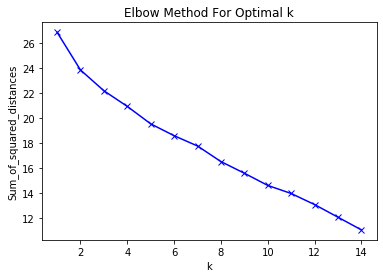

In [21]:
import collections

# set number of clusters
K = range(1,15)
metricScoresDf = pd.DataFrame(columns=('K','Silhouette', ' Harabasz'))

toronto_grouped_clustering = toronto_grouped.drop('PostalCode', 1)

# run k-means clustering
Sum_of_squared_distances = []
for k in K:
    k_means = KMeans(n_clusters=k, random_state = 0)
    model = k_means.fit(toronto_grouped_clustering)
    Sum_of_squared_distances.append(k_means.inertia_)
    y_hat = k_means.predict(toronto_grouped_clustering)
    labels = k_means.labels_
    if k != 1:
        silhouette = metrics.silhouette_score(toronto_grouped_clustering, labels, metric = 'euclidean')
        harabasz = metrics.calinski_harabasz_score(toronto_grouped_clustering, labels)
        modelSplit = collections.Counter(model.labels_).values()
        metricScoresDf = metricScoresDf.append({'K':k,'Silhouette':silhouette, ' Harabasz':harabasz, 'Model Split':modelSplit}, ignore_index = True)

display(metricScoresDf)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()
# check cluster labels generated for each row in the dataframe
#kmeans.labels_[0:10] 

### Moving forward

Despite trying to clean up the data this model has not improved much if at all.  After a small bit of research I think I will try using the init = k-means ++ parameter to see if this provides any improvement

,K,Silhouette,Harabasz,Model Split
0,2,0.361398,10.357736,"(80, 4)"
1,3,0.357411,9.386621,"(77, 4, 3)"
2,4,0.360851,7.776638,"(76, 4, 3, 1)"
3,5,0.351648,7.388000,"(74, 4, 1, 2, 3)"
4,6,0.305896,6.837741,"(72, 4, 2, 2, 3, 1)"
5,7,0.098875,6.717882,"(24, 4, 48, 1, 3, 3, 1)"
6,8,0.099178,6.707105,"(27, 4, 45, 1, 1, 2, 3, 1)"
7,9,0.102722,6.703636,"(26, 4, 45, 1, 1, 2, 3, 1, 1)"
8,10,0.110927,6.812984,"(24, 4, 46, 1, 1, 2, 3, 1, 1, 1)"
9,11,0.115909,7.006964,"(24, 4, 45, 1, 1, 1, 2, 3, 1, 1, 1)"


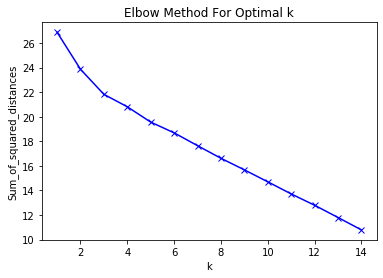

In [114]:
# set number of clusters
K = range(1,15)
metricScoresDf = pd.DataFrame(columns=('K','Silhouette', ' Harabasz'))

toronto_grouped_clustering = toronto_grouped.drop('PostalCode', 1)

# run k-means clustering
Sum_of_squared_distances = []
for k in K:
    k_means = KMeans(init = 'k-means++', n_clusters=k, random_state=2)
    model = k_means.fit(toronto_grouped_clustering)
    Sum_of_squared_distances.append(k_means.inertia_)
    y_hat = k_means.predict(toronto_grouped_clustering)
    labels = k_means.labels_
    if k != 1:
        silhouette = metrics.silhouette_score(toronto_grouped_clustering, labels, metric = 'euclidean')
        harabasz = metrics.calinski_harabasz_score(toronto_grouped_clustering, labels)
        modelSplit = collections.Counter(model.labels_).values()
        metricScoresDf = metricScoresDf.append({'K':k,'Silhouette':silhouette, ' Harabasz':harabasz, 'Model Split':modelSplit}, ignore_index = True)

display(metricScoresDf)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

### Final Model

Having run a few different clusters off-line I found most to be higly skewed to one value.  6 clusters provided a bit more of a spread with the results so we will go with 6

In [71]:
k_means = KMeans(init = 'k-means++', n_clusters=6)
model = k_means.fit(toronto_grouped_clustering)
# check cluster labels generated for each row in the dataframe
model.labels_[0:10] 

array([1, 2, 1, 1, 1, 1, 5, 2, 5, 5], dtype=int32)

In [73]:
# add clustering labels
postalCode_venues_sorted.drop(['Cluster Labels'], axis=1, inplace=True)
postalCode_venues_sorted.insert(0, 'Cluster Labels', model.labels_)
postalCode_venues_sorted

,Cluster Labels,PostalCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,M1E,Fast Food Restaurant,Coffee Shop,Pizza Place,Pharmacy,Restaurant,Breakfast Spot,Fried Chicken Joint,Beer Store,Supermarket,Intersection
1,2,M1H,Construction & Landscaping,Yoga Studio,Diner,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
2,1,M1J,Sandwich Place,Big Box Store,Yoga Studio,Fish Market,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Ethiopian Restaurant,Electronics Store
3,1,M1K,Discount Store,Hobby Shop,Coffee Shop,Department Store,Yoga Studio,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Ethiopian Restaurant
4,1,M1L,Intersection,Bus Station,Coffee Shop,Yoga Studio,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Ethiopian Restaurant,Electronics Store
...,...,...,...,...,...,...,...,...,...,...,...,...
79,1,M9N,Farmers Market,Pharmacy,Yoga Studio,Dessert Shop,Farm,Falafel Restaurant,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Donut Shop
80,1,M9P,Pizza Place,Chinese Restaurant,Sandwich Place,Coffee Shop,Discount Store,Dessert Shop,Farm,Falafel Restaurant,Ethiopian Restaurant,Electronics Store
81,1,M9R,Coffee Shop,Pharmacy,Pizza Place,Liquor Store,Bank,Yoga Studio,Diner,Farmers Market,Farm,Falafel Restaurant
82,5,M9V,Fast Food Restaurant,Grocery Store,Beer Store,Pizza Place,Pharmacy,Fried Chicken Joint,Video Store,Hardware Store,Electronics Store,Dessert Shop


In [83]:
# add clustering labels
postalCode_venues_sorted.drop(['Cluster Labels'], axis=1, inplace=True)
postalCode_venues_sorted.insert(0, 'Cluster Labels', model.labels_)

toronto_merged = dfToronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(postalCode_venues_sorted.set_index('PostalCode'), on='PostalCode')

# Drop where we did not have enough info to cluster
toronto_merged.dropna(subset = ["Cluster Labels"], inplace=True)
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)
display(toronto_merged)

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,M4A,North York,Victoria Village,43.728102,-79.311890,1,Intersection,Coffee Shop,Pizza Place,Yoga Studio,Farmers Market,Farm,Falafel Restaurant,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.650964,-79.353041,5,Pub,Chocolate Shop,Thai Restaurant,Café,Distribution Center,French Restaurant,Bank,Bakery,Mexican Restaurant,Tech Startup
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.723265,-79.451211,5,Clothing Store,American Restaurant,Cosmetics Shop,Restaurant,Food Court,Bookstore,Furniture / Home Store,Seafood Restaurant,Department Store,Jewelry Store
7,M3B,North York,Don Mills,43.748900,-79.357220,1,Spa,Bank,Restaurant,Athletics & Sports,Coffee Shop,Farmers Market,Farm,Falafel Restaurant,Ethiopian Restaurant,Electronics Store
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.707193,-79.311529,5,Fast Food Restaurant,Bank,Gastropub,Gym / Fitness Center,Rock Climbing Spot,Breakfast Spot,Athletics & Sports,Pizza Place,Pet Store,Pharmacy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,M5X,Downtown Toronto,"First Canadian Place, Underground city",43.648269,-79.381884,1,Coffee Shop,Burger Joint,American Restaurant,Gym / Fitness Center,Bakery,Discount Store,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653340,-79.509766,5,Smoke Shop,Diner,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Donut Shop
99,M4Y,Downtown Toronto,Church and Wellesley,43.666659,-79.381472,5,Coffee Shop,Restaurant,Japanese Restaurant,Sushi Restaurant,Café,Gay Bar,Dance Studio,Grocery Store,Mediterranean Restaurant,Men's Store
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.632798,-79.493017,1,Bank,Yoga Studio,Discount Store,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant


In [115]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
kclusters = 8
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' in Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Map display for Github

Folium maps do not always display in github so I have added a workaround below

In [91]:
#import folium
#from IPython.display import display
display(map_clusters)

In [92]:
display(toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]])
display(toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]])
display(toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]])
display(toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]])
display(toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]])
display(toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]])

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
53,Downsview,0,Business Service,Yoga Studio,Discount Store,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
54,Studio District,0,Business Service,Government Building,Yoga Studio,Diner,Farmers Market,Farm,Falafel Restaurant,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant


,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Victoria Village,1,Intersection,Coffee Shop,Pizza Place,Yoga Studio,Farmers Market,Farm,Falafel Restaurant,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
7,Don Mills,1,Spa,Bank,Restaurant,Athletics & Sports,Coffee Shop,Farmers Market,Farm,Falafel Restaurant,Ethiopian Restaurant,Electronics Store
9,"Garden District, Ryerson",1,Coffee Shop,Clothing Store,Restaurant,Hotel,Café,Tea Room,Fast Food Restaurant,Ramen Restaurant,Bar,Burger Joint
11,"West Deane Park, Princess Gardens, Martin Grov...",1,Pizza Place,Tea Room,Sandwich Place,Dessert Shop,Farm,Falafel Restaurant,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Donut Shop
17,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",1,Convenience Store,Cosmetics Shop,Pet Store,Coffee Shop,Pizza Place,Café,Liquor Store,Beer Store,Yoga Studio,Donut Shop
18,"Guildwood, Morningside, West Hill",1,Fast Food Restaurant,Coffee Shop,Pizza Place,Pharmacy,Restaurant,Breakfast Spot,Fried Chicken Joint,Beer Store,Supermarket,Intersection
24,Central Bay Street,1,Coffee Shop,Bubble Tea Shop,Middle Eastern Restaurant,Poke Place,Japanese Restaurant,Ramen Restaurant,Gastropub,Hotel,Sushi Restaurant,Spa
28,"Bathurst Manor, Wilson Heights, Downsview North",1,Bank,Coffee Shop,Sushi Restaurant,Deli / Bodega,Bridal Shop,Pizza Place,Supermarket,Ice Cream Shop,Gas Station,Pharmacy
29,Thorncliffe Park,1,Yoga Studio,Gas Station,Sandwich Place,Coffee Shop,Housing Development,Supermarket,Farm,Falafel Restaurant,Ethiopian Restaurant,Electronics Store
32,Scarborough Village,1,Sandwich Place,Big Box Store,Yoga Studio,Fish Market,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Ethiopian Restaurant,Electronics Store


,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,Cedarbrae,2,Construction & Landscaping,Yoga Studio,Diner,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
39,Bayview Village,2,Construction & Landscaping,Yoga Studio,Diner,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
50,Humber Summit,2,Construction & Landscaping,Yoga Studio,Diner,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
65,"Dorset Park, Wexford Heights, Scarborough Town...",2,Brewery,Construction & Landscaping,Discount Store,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Ethiopian Restaurant,Electronics Store


,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Humewood-Cedarvale,3,Grocery Store,Yoga Studio,Dessert Shop,Farmers Market,Farm,Falafel Restaurant,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Donut Shop
88,"New Toronto, Mimico South, Humber Bay Shores",3,Grocery Store,Yoga Studio,Dessert Shop,Farmers Market,Farm,Falafel Restaurant,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Donut Shop
91,Rosedale,3,Grocery Store,Candy Store,Yoga Studio,Diner,Farmers Market,Farm,Falafel Restaurant,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant


,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
52,"Willowdale, Newtonbrook",4,Bridal Shop,Yoga Studio,Discount Store,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant


,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,"Regent Park, Harbourfront",5,Pub,Chocolate Shop,Thai Restaurant,Café,Distribution Center,French Restaurant,Bank,Bakery,Mexican Restaurant,Tech Startup
3,"Lawrence Manor, Lawrence Heights",5,Clothing Store,American Restaurant,Cosmetics Shop,Restaurant,Food Court,Bookstore,Furniture / Home Store,Seafood Restaurant,Department Store,Jewelry Store
8,"Parkview Hill, Woodbine Gardens",5,Fast Food Restaurant,Bank,Gastropub,Gym / Fitness Center,Rock Climbing Spot,Breakfast Spot,Athletics & Sports,Pizza Place,Pet Store,Pharmacy
10,Glencairn,5,Gas Station,Grocery Store,Pub,Sushi Restaurant,Pizza Place,Fast Food Restaurant,Cosmetics Shop,Creperie,Farm,Falafel Restaurant
14,Woodbine Heights,5,Pet Store,Bar,Gas Station,Music Store,Arts & Crafts Store,Grocery Store,Breakfast Spot,Pharmacy,Eastern European Restaurant,Distribution Center
15,St. James Town,5,Gastropub,Japanese Restaurant,Salon / Barbershop,Gym,Cosmetics Shop,Creperie,Restaurant,Hotel,Italian Restaurant,BBQ Joint
19,The Beaches,5,Pub,Health Food Store,Church,Yoga Studio,Farmers Market,Farm,Falafel Restaurant,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
20,Berczy Park,5,Seafood Restaurant,Restaurant,Café,Cheese Shop,Beer Bar,Cocktail Bar,Coffee Shop,Breakfast Spot,Museum,Pub
21,Caledonia-Fairbanks,5,Women's Store,Sporting Goods Shop,Fish Market,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
23,Leaside,5,Burger Joint,Coffee Shop,Sporting Goods Shop,Sports Bar,Bank,Grocery Store,Sushi Restaurant,Portuguese Restaurant,Restaurant,Fish & Chips Shop


In [64]:
12.99 + 10.99 + 19.50 + 8.99



52.470000000000006

In [63]:
50 -t

6.519999999999996

In [100]:
#import collections
display(model.labels_)
counter = 3
display(collections.Counter(model.labels_).values())

array([1, 2, 1, 1, 1, 1, 5, 2, 5, 5, 1, 1, 5, 5, 2, 1, 4, 5, 1, 1, 1, 1,
       1, 1, 0, 5, 1, 5, 5, 5, 5, 1, 5, 5, 0, 5, 1, 1, 3, 1, 5, 5, 1, 5,
       5, 1, 5, 5, 5, 1, 1, 5, 5, 5, 5, 1, 5, 5, 3, 5, 5, 5, 5, 5, 5, 1,
       1, 5, 5, 5, 3, 1, 5, 1, 1, 1, 1, 2, 5, 1, 1, 1, 5, 5], dtype=int32)

dict_values([34, 4, 40, 1, 2, 3])